In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from time import time

from oracles import BinaryLogistic
from optimization import GDClassifier, SGDClassifier, accuracy
from utils import grad_finite_diff

In [103]:
import oracles, optimization, utils
from importlib import reload

reload(oracles)
reload(optimization)
reload(utils)

from oracles import BinaryLogistic
from optimization import GDClassifier, SGDClassifier, accuracy
from utils import grad_finite_diff

In [3]:
mpl.rc('font', size=15)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(style="darkgrid")

In [4]:
train = pd.read_csv("data_toxic/toxic_train.csv")
test = pd.read_csv("data_toxic/toxic_test.csv")
train

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False
...,...,...,...
52056,159494,"""\n\n our previous conversation \n\nyou fuckin...",True
52057,159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,True
52058,159541,Your absurd edits \n\nYour absurd edits on gre...,True
52059,159546,"""\n\nHey listen don't you ever!!!! Delete my e...",True


In [5]:
test

,Unnamed: 0,comment_text,is_toxic
0,0,Thank you for understanding. I think very high...,False
1,1,:Dear god this site is horrible.,False
2,2,"""::: Somebody will invariably try to add Relig...",False
3,3,""" \n\n It says it right there that it IS a typ...",False
4,4,""" \n\n == Before adding a new product to the l...",False
...,...,...,...
20671,63877,NIGEL IS A CRAZY IDIOT!!!,True
20672,63935,""" \n ::Well, now don't I feel stupid.... · """,True
20673,63945,==Fourth Baldrick possibly being cleverer than...,True
20674,63962,""" \n\n == IRAN == \n That’s right, Iran. It wa...",True


## EXP1

In [6]:
for data in [train, test]:
    data["comment_text"] = data["comment_text"].str.lower().str.replace("[^a-z0-9]", " ", regex=True).str.strip()

In [7]:
train.head(10)

,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on impr...,False
4,4,you sir are my hero any chance you remember...,False
5,5,congratulations from me as well use the tools...,False
6,6,cocksucker before you piss around on my work,True
7,7,your vandalism to the matt shirvington article...,False
8,8,sorry if the word nonsense was offensive to ...,False
9,9,alignment on this subject and which are contra...,False


In [8]:
def savefig(name):
    plt.savefig(f"figures/{name}.pdf", bbox_inches='tight')

## EXP2

In [9]:
from sklearn.feature_extraction.text import CountVectorizer


count_vectorizer = CountVectorizer(min_df=0.007)
X_train = count_vectorizer.fit_transform(train["comment_text"])
X_test = count_vectorizer.transform(test["comment_text"])
y_train = 2 * train["is_toxic"].values - 1
y_test = 2 * test["is_toxic"].values - 1

In [10]:
X_train.shape

(52061, 774)

## EXP3

In [11]:
oracle = BinaryLogistic(l2_coef=1)

def Q(w):
    return oracle.func(X_train, y_train, w)

In [12]:
from tqdm import tqdm


# w ~ U[a, b]
a = -1
b = 1

N_iters = 10

time_numeric = np.zeros(N_iters)
time_analytical = np.zeros(N_iters)
dif_norm = np.zeros(N_iters)

np.random.seed(42)
for i in tqdm(range(N_iters)):
    w = (b - a) * np.random.random(X_train.shape[1]) + a
    t1 = time()
    grad_numerical = grad_finite_diff(Q, w)
    t2 = time()
    grad_analytical = oracle.grad(X_train, y_train, w)
    t3 = time()
    time_numeric[i] = t2 - t1
    time_analytical[i] = t3 - t2
    dif_norm = np.linalg.norm(grad_numerical - grad_analytical)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:18<00:00, 19.86s/it]


In [13]:
mean_time_numeric = time_numeric.mean()
mean_time_analytical = time_analytical.mean()
mean_dif_norm = dif_norm.mean()
print(f"{mean_time_numeric = :.2f} с.")
print(f"{mean_time_analytical = :.2f} с.")
print(f"{mean_dif_norm = }")
print(f"Расчет градиента по аналитической формуле быстрее, чем численный расчет в {mean_time_numeric / mean_time_analytical:.2f}")

mean_time_numeric = 19.82 с.
mean_time_analytical = 0.05 с.
mean_dif_norm = 3.764992494475117e-05
Расчет градиента по аналитической формуле быстрее, чем численный расчет в 436.73


1. Расчет градиента по аналитической формуле быстрее, чем численный расчет в 436 раз
2. При многократном численном расчете накапливается ошибка

## EXP4: GDC

### step_alpha

In [14]:
STEP_BETA = 1
MAX_ITER = 30
#N_POINTS = 7
#step_alpha_arr_gd = np.linspace(0.2, 3,  N_POINTS)
step_alpha_arr_gd = np.array([0.1, 0.5, 1, 1.5, 2, 2.5, 3])

loss_arr_gd_alpha = np.zeros((step_alpha_arr_gd.shape[0], MAX_ITER + 1))
acc_arr_gd_alpha = np.zeros_like(loss_arr_gd_alpha)

for step_alpha_idx, step_alpha in enumerate(tqdm(step_alpha_arr_gd)):
    gdc = GDClassifier(step_alpha=step_alpha, step_beta=STEP_BETA, max_iter=MAX_ITER, tolerance=0)
    history = gdc.fit(X_train, y_train, trace=True)
    loss_arr_gd_alpha[step_alpha_idx] = np.array(history["func"])
    acc_arr_gd_alpha[step_alpha_idx] = np.array(history["accuracy"])

100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


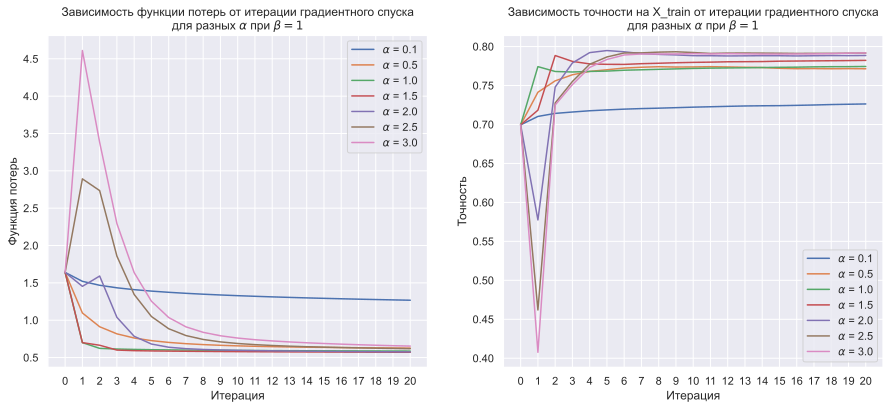

In [15]:
n_iters = 21
plt.figure(figsize=(15, 6))
x = np.arange(0, MAX_ITER + 1)[:n_iters]

plt.subplot(1, 2, 1)
for i in range(loss_arr_gd_alpha.shape[0]):
    plt.plot(x, loss_arr_gd_alpha[i, :n_iters], label=f"$\\alpha$ = {step_alpha_arr_gd[i]:.1f}")
    plt.title(f"Зависимость функции потерь от итерации градиентного спуска\nдля разных $\\alpha$ при $\\beta = {STEP_BETA}$")
    plt.xlabel("Итерация")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x)

plt.subplot(1, 2, 2)
for i in range(acc_arr_gd_alpha.shape[0]):
    plt.plot(x, acc_arr_gd_alpha[i, :n_iters], label=f"$\\alpha$ = {step_alpha_arr_gd[i]:.1f}")
    plt.title(f"Зависимость точности на X_train от итерации градиентного спуска\nдля разных $\\alpha$ при $\\beta = {STEP_BETA}$")
    plt.xlabel("Итерация")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x)

savefig("4_alpha")
plt.show()

1. Слишком маленькие alpha - плохо (очень долгая сходимость).
2. Чем больше alpha, тем больше шаги градиентного спуска, и при больших alpha наблюдаются сильные колебания.
3. При этом если посмотреть на график точности, то видно, что большие alpha на более поздних итерациях дают бОльшую точность.
4. Параметр alpha влияет больше на начальных итерациях, чем на более поздних.

### step_beta

In [16]:
STEP_ALPHA = 1
MAX_ITER_GD_BETA = 100
#N_POINTS = 7
#step_beta_arr_gd = np.linspace(0.01, 2,  N_POINTS)
step_beta_arr_gd = np.array([0.01, 0.1, 0.5, 1, 1.5, 2])

loss_arr_gd_beta = np.zeros((step_beta_arr_gd.shape[0], MAX_ITER_GD_BETA + 1))
acc_arr_gd_beta = np.zeros_like(loss_arr_gd_beta)

for step_beta_idx, step_beta in enumerate(tqdm(step_beta_arr_gd)):
    gdc = GDClassifier(step_alpha=STEP_ALPHA, step_beta=step_beta, max_iter=MAX_ITER_GD_BETA, tolerance=0)
    history = gdc.fit(X_train, y_train, trace=True)
    loss_arr_gd_beta[step_beta_idx] = np.array(history["func"])
    acc_arr_gd_beta[step_beta_idx] = np.array(history["accuracy"])

100%|██████████| 6/6 [00:55<00:00,  9.26s/it]


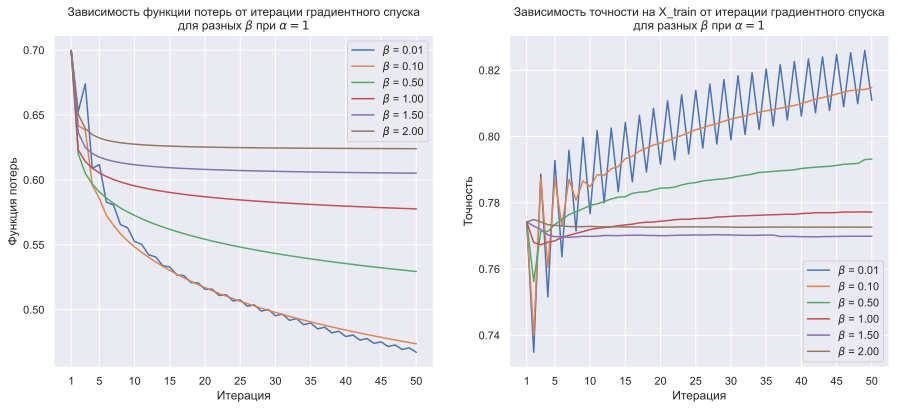

In [17]:
n_iters = 51
plt.figure(figsize=(15, 6))
x = np.arange(1, n_iters)
x_ticks = [1] + [i for i in range(5, 51, 5)]

plt.subplot(1, 2, 1)
for i in range(loss_arr_gd_beta.shape[0]):
    plt.plot(x, loss_arr_gd_beta[i, 1:n_iters], label=f"$\\beta$ = {step_beta_arr_gd[i]:.2f}")
    plt.title(f"Зависимость функции потерь от итерации градиентного спуска\nдля разных $\\beta$ при $\\alpha = {STEP_ALPHA}$")
    plt.xlabel("Итерация")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(acc_arr_gd_beta.shape[0]):
    plt.plot(x, acc_arr_gd_beta[i, 1:n_iters], label=f"$\\beta$ = {step_beta_arr_gd[i]:.2f}")
    plt.title(f"Зависимость точности на X_train от итерации градиентного спуска\nдля разных $\\beta$ при $\\alpha = {STEP_ALPHA}$")
    plt.xlabel("Итерация")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)

savefig("4_beta")
plt.show()

1. Чем меньше beta, тем медленнее убывает шаг градиентного спуска.
2. Небольшие beta показывают себя лучше всего по сходимости. Но если брать очень маленькое beta = 0.01, то функции потерь и точности осциллируют (колеблются), более выигрышным в этом плане смотрится beta=0.1, поскольку при нем графики осциллируют намного меньше, но при этом значения функций получаются примерно такими же, как и в случае beta = 0.01.
3. При beta = 0.1 график точности осциллирует на первых итерациях.
4. Параметр beta оказывает бОльшее влияние на более поздних итерациях, чем на начальных.

### alpha и beta

Изобразим графки функции потерь и точности для разных alpha и betta.

In [18]:
MAX_ITER_GD_A_B = 50

step_a_b_arr_gd = np.array([(0.5, 0.1), (1, 0.1), (1.5, 0.1), (0.5, 0.5), (1, 0.5), (1.5, 0.5)])

loss_arr_gd_a_b = np.zeros((step_a_b_arr_gd.shape[0], MAX_ITER_GD_A_B + 1))
acc_arr_gd_a_b = np.zeros_like(loss_arr_gd_a_b)

for i, (step_alpha, step_beta) in enumerate(tqdm(step_a_b_arr_gd)):
    gdc = GDClassifier(step_alpha=step_alpha, step_beta=step_beta, max_iter=MAX_ITER_GD_A_B, tolerance=0)
    history = gdc.fit(X_train, y_train, trace=True)
    loss_arr_gd_a_b[i] = np.array(history["func"])
    acc_arr_gd_a_b[i] = np.array(history["accuracy"])

100%|██████████| 6/6 [00:38<00:00,  6.38s/it]


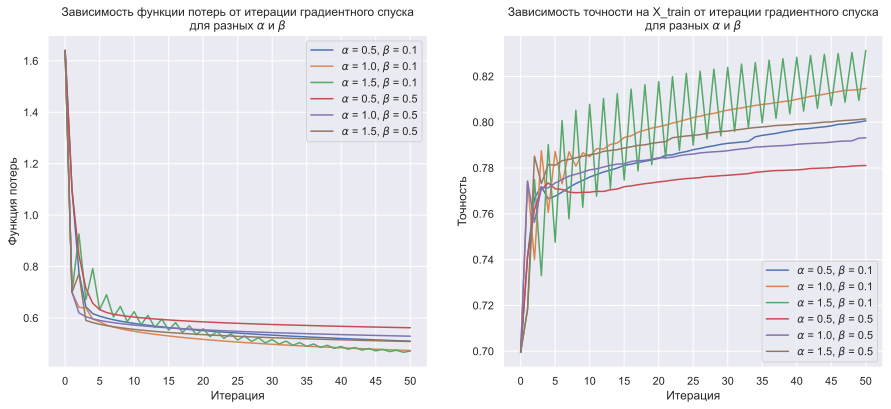

In [19]:
n_iters = 51
plt.figure(figsize=(15, 6))
x = np.arange(0, n_iters)
x_ticks = np.arange(0, 51, 5)

plt.subplot(1, 2, 1)
for i in range(loss_arr_gd_a_b.shape[0]):
    plt.plot(x, loss_arr_gd_a_b[i, :n_iters], label=f"$\\alpha$ = {step_a_b_arr_gd[i][0]:.1f}, $\\beta$ = {step_a_b_arr_gd[i][1]:.1f}")
    plt.title(f"Зависимость функции потерь от итерации градиентного спуска\nдля разных $\\alpha$ и $\\beta$")
    plt.xlabel("Итерация")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(acc_arr_gd_a_b.shape[0]):
    plt.plot(x, acc_arr_gd_a_b[i, :n_iters], label=f"$\\alpha$ = {step_a_b_arr_gd[i][0]:.1f}, $\\beta$ = {step_a_b_arr_gd[i][1]:.1f}")
    plt.title(f"Зависимость точности на X_train от итерации градиентного спуска\nдля разных $\\alpha$ и $\\beta$")
    plt.xlabel("Итерация")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)

savefig("4_alpha_beta")
plt.show()

Наиболее отимальным по скорости сходимости и отсутствии сильной осцилляции из рассмотренных является случай, когда alpha = 1, beta = 0.1.

In [20]:
step_alpha_gd = 1
step_beta_gd = 0.1

### $w_0$

1. $w_j^{(0)} = 0$
2. $w_j^{(0)} \sim U[-1, 1]$
3. $w_j^{(0)} = \dfrac{(y, f_j)}{(f_j, f_j)}$

In [44]:
a = -1
b = 1

MAX_ITER_GD_W = 100

np.random.seed(42)
w_0_list = [np.zeros(X_train.shape[1]), (b - a) * np.random.random(X_train.shape[1]) + a, None]

loss_arr_gd_w = np.zeros((len(w_0_list), MAX_ITER_GD_W + 1))
acc_arr_gd_w = np.zeros_like(loss_arr_gd_w)

for i, w_0 in enumerate(tqdm(w_0_list)):
    gdc = GDClassifier(step_alpha=step_alpha_gd, step_beta=step_beta_gd, max_iter=MAX_ITER_GD_W, tolerance=0)
    history = gdc.fit(X_train, y_train, trace=True, w_0=w_0)
    loss_arr_gd_w[i] = np.array(history["func"])
    acc_arr_gd_w[i] = np.array(history["accuracy"])

100%|██████████| 3/3 [00:23<00:00,  7.96s/it]


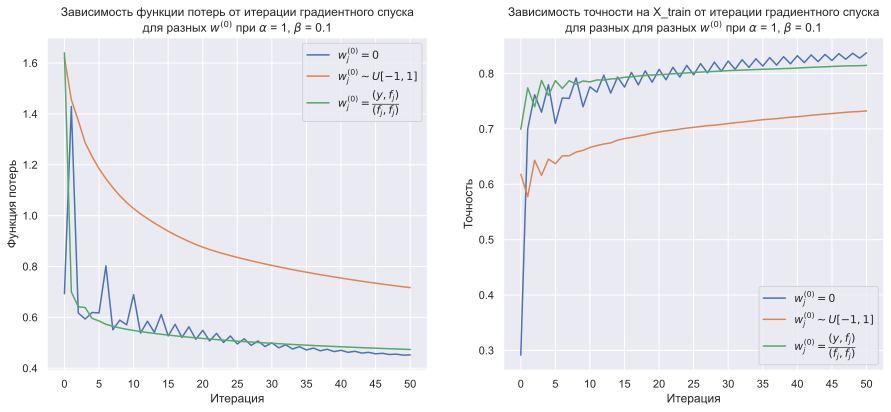

In [45]:
n_iters = 51
plt.figure(figsize=(15, 6))
x = np.arange(0, n_iters)
x_ticks = np.arange(0, 51, 5)

plt.subplot(1, 2, 1)

labels = ["$w_j^{(0)} = 0$", r"$w_j^{(0)} \sim U[-1, 1]$", r"$w_j^{(0)} = \dfrac{(y, f_j)}{(f_j, f_j)}$"]

title_add = f" при $\\alpha$ = {step_alpha_gd}, $\\beta$ = {step_beta_gd}"

for i in range(loss_arr_gd_w.shape[0]):
    plt.plot(x, loss_arr_gd_w[i, :n_iters], label=labels[i])
    plt.title("Зависимость функции потерь от итерации градиентного спуска\nдля разных $w^{(0)}$" + title_add)
    plt.xlabel("Итерация")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(loss_arr_gd_w.shape[0]):
    plt.plot(x, acc_arr_gd_w[i, :n_iters], label=labels[i])
    plt.title("Зависимость точности на X_train от итерации градиентного спуска\nдля разных для разных $w^{(0)}$" + title_add)
    plt.xlabel("Итерация")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)
    #plt.yscale("log")

savefig("4_w_0")
plt.show()

## EXP5: SGDC

### step_alpha

In [52]:
STEP_BETA_SGD = 1
MAX_ITER_SGD_A = 30
BATCH_SIZE = 1000
#N_POINTS = 7
#step_alpha_arr_gd = np.linspace(0.2, 3,  N_POINTS)
step_alpha_arr_sgd = np.array([0.1, 0.5, 1, 1.5, 2, 2.5, 3])

loss_arr_sgd_alpha = np.zeros((step_alpha_arr_sgd.shape[0], MAX_ITER_SGD_A + 1))
acc_arr_sgd_alpha = np.zeros_like(loss_arr_sgd_alpha)
epoch_arr_alpha = np.zeros_like(loss_arr_sgd_alpha)

for step_alpha_idx, step_alpha in enumerate(tqdm(step_alpha_arr_sgd)):
    sgdc = SGDClassifier(step_alpha=step_alpha, step_beta=STEP_BETA_SGD, max_iter=MAX_ITER_SGD_A, tolerance=0, batch_size=BATCH_SIZE)
    history = sgdc.fit(X_train, y_train, trace=True)
    loss_arr_sgd_alpha[step_alpha_idx] = np.array(history["func"])
    acc_arr_sgd_alpha[step_alpha_idx] = np.array(history["accuracy"])
    epoch_arr_alpha[step_alpha_idx] = np.array(history["epoch_num"])

100%|██████████| 7/7 [00:23<00:00,  3.31s/it]


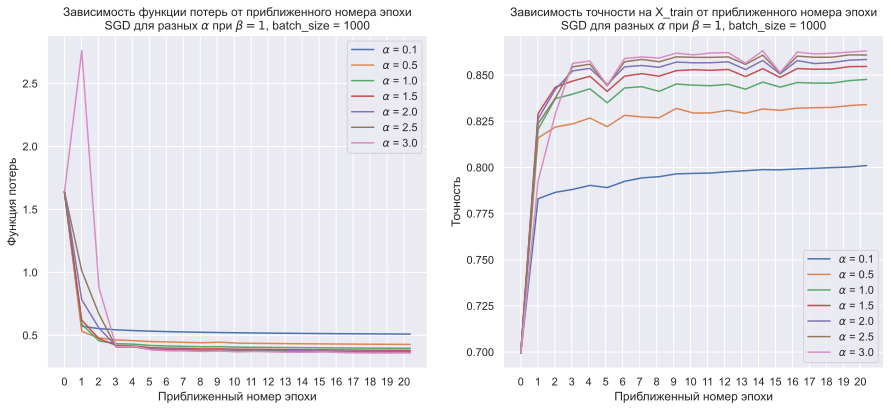

In [53]:
n_iters = 21
plt.figure(figsize=(15, 6))
x_ticks = np.arange(0, n_iters)

plt.subplot(1, 2, 1)
for i in range(loss_arr_sgd_alpha.shape[0]):
    plt.plot(epoch_arr_alpha[i][:n_iters], loss_arr_sgd_alpha[i, :n_iters], label=f"$\\alpha$ = {step_alpha_arr_sgd[i]:.1f}")
    plt.title(f"Зависимость функции потерь от приближенного номера эпохи\nSGD для разных $\\alpha$ при $\\beta = {STEP_BETA_SGD}$, batch_size = {BATCH_SIZE}")
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(acc_arr_sgd_alpha.shape[0]):
    plt.plot(epoch_arr_alpha[i][:n_iters], acc_arr_sgd_alpha[i, :n_iters], label=f"$\\alpha$ = {step_alpha_arr_sgd[i]:.1f}")
    plt.title(f"Зависимость точности на X_train от приближенного номера эпохи\nSGD для разных $\\alpha$ при $\\beta = {STEP_BETA_SGD}$, batch_size = {BATCH_SIZE}")
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)

savefig("5_alpha")
plt.show()

1. Аналогиные выводы как для gd.
2. Отличие: при маленьких alpha (=0.1) появилась сходимость функции потерь (шаг не точен, нужны нгебольшие alpha)

### step_beta

In [25]:
STEP_ALPHA_SGD = 1
MAX_ITER_SGD_BETA = 100
#N_POINTS = 7
#step_beta_arr_gd = np.linspace(0.01, 2,  N_POINTS)
step_beta_arr_sgd = np.array([0.01, 0.1, 0.5, 1, 1.5, 2])

loss_arr_sgd_beta = np.zeros((step_beta_arr_sgd.shape[0], MAX_ITER_SGD_BETA + 1))
acc_arr_sgd_beta = np.zeros_like(loss_arr_sgd_beta)
epoch_arr_beta = np.zeros_like(loss_arr_sgd_beta)

for step_beta_idx, step_beta in enumerate(tqdm(step_beta_arr_sgd)):
    sgdc = SGDClassifier(step_alpha=STEP_ALPHA_SGD, step_beta=step_beta, max_iter=MAX_ITER_SGD_BETA, tolerance=0, batch_size=BATCH_SIZE)
    history = sgdc.fit(X_train, y_train, trace=True)
    loss_arr_sgd_beta[step_beta_idx] = np.array(history["func"])
    acc_arr_sgd_beta[step_beta_idx] = np.array(history["accuracy"])
    epoch_arr_beta[step_beta_idx] = np.array(history["epoch_num"])

100%|██████████| 6/6 [00:49<00:00,  8.19s/it]


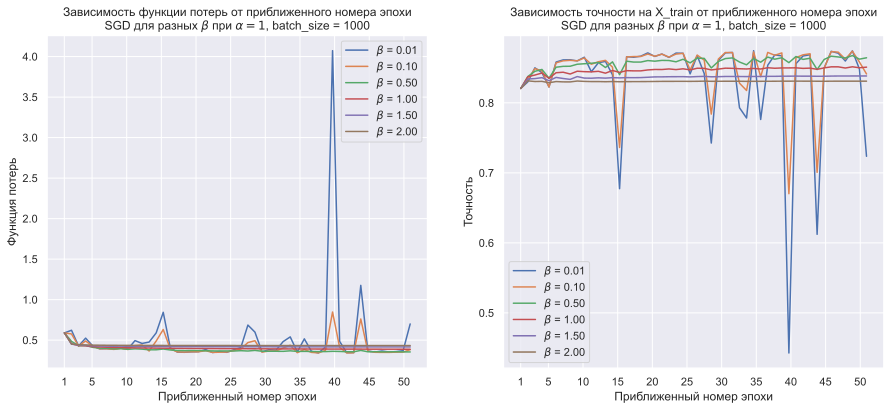

In [26]:
n_iters = 51
plt.figure(figsize=(15, 6))
x_ticks = [1] + [i for i in range(5, 51, 5)]

plt.subplot(1, 2, 1)
for i in range(loss_arr_sgd_beta.shape[0]):
    plt.plot(epoch_arr_beta[i][1:n_iters], loss_arr_sgd_beta[i, 1:n_iters], label=f"$\\beta$ = {step_beta_arr_sgd[i]:.2f}")
    plt.title(f"Зависимость функции потерь от приближенного номера эпохи\nSGD для разных $\\beta$ при $\\alpha = {STEP_ALPHA_SGD}$, batch_size = {BATCH_SIZE}")
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(acc_arr_sgd_beta.shape[0]):
    plt.plot(epoch_arr_beta[i][1:n_iters], acc_arr_sgd_beta[i, 1:n_iters], label=f"$\\beta$ = {step_beta_arr_sgd[i]:.2f}")
    plt.title(f"Зависимость точности на X_train от приближенного номера эпохи\nSGD для разных $\\beta$ при $\\alpha = {STEP_ALPHA_SGD}$, batch_size = {BATCH_SIZE}")
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)

savefig("5_beta")
plt.show()

1. Наблюдаются резкие увеличения функции потерь / снижения точности для маленьких beta. Вследствие неточного вычисления градиента при маленьких beta множитель перед градиентом, посчитанным по подвыборке будет достаточно большим, чтобы градиент, вычисленный с ошибкой, выбросил нас из окресности оптимума.
2. beta_best = 0.5 

### alpha и beta

In [27]:
MAX_ITER_SGD_A_B = 50

# alpha: 1, 2
# beta: 0.1, 0.5, 1.0

step_a_b_arr_sgd = np.array([(1.0, 0.5), (1.0, 1.0), (2.0, 0.5), (2.0, 1.0)])

loss_arr_sgd_a_b = np.zeros((step_a_b_arr_sgd.shape[0], MAX_ITER_SGD_A_B + 1))
acc_arr_sgd_a_b = np.zeros_like(loss_arr_sgd_a_b)
epoch_arr_a_b = np.zeros_like(loss_arr_sgd_a_b)

for i, (step_alpha, step_beta) in enumerate(tqdm(step_a_b_arr_sgd)):
    sgdc = SGDClassifier(step_alpha=step_alpha, step_beta=step_beta, max_iter=MAX_ITER_SGD_A_B, tolerance=0, batch_size=BATCH_SIZE)
    history = sgdc.fit(X_train, y_train, trace=True)
    loss_arr_sgd_a_b[i] = np.array(history["func"])
    acc_arr_sgd_a_b[i] = np.array(history["accuracy"])
    epoch_arr_a_b[i] = np.array(history["epoch_num"])

100%|██████████| 4/4 [00:19<00:00,  4.84s/it]


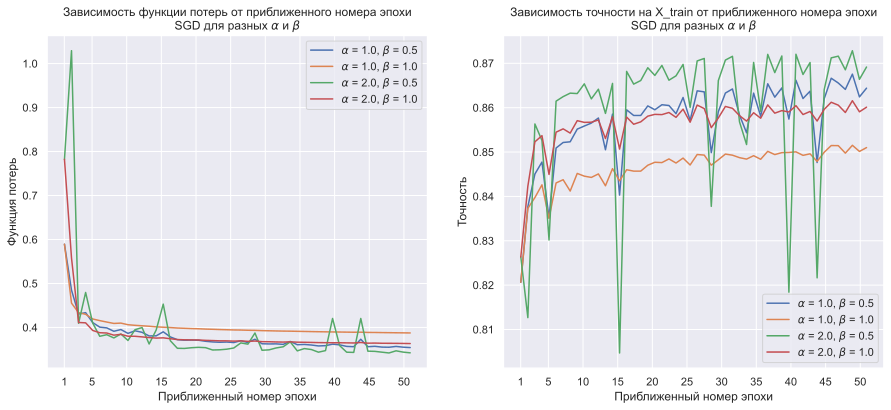

In [60]:
n_iters = 51
plt.figure(figsize=(15, 6))
x_ticks = [1] + [i for i in range(5, 51, 5)]

plt.subplot(1, 2, 1)
for i in range(loss_arr_sgd_a_b.shape[0]):
    plt.plot(epoch_arr_a_b[i][1:n_iters], loss_arr_sgd_a_b[i, 1:n_iters], label=f"$\\alpha$ = {step_a_b_arr_sgd[i][0]:.1f}, $\\beta$ = {step_a_b_arr_sgd[i][1]:.1f}")
    plt.title(f"Зависимость функции потерь от приближенного номера эпохи\nSGD для разных $\\alpha$ и $\\beta$")
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(acc_arr_sgd_a_b.shape[0]):
    plt.plot(epoch_arr_a_b[i][1:n_iters], acc_arr_sgd_a_b[i, 1:n_iters], label=f"$\\alpha$ = {step_a_b_arr_sgd[i][0]:.1f}, $\\beta$ = {step_a_b_arr_sgd[i][1]:.1f}")
    plt.title(f"Зависимость точности на X_train от приближенного номера эпохи\nSGD для разных $\\alpha$ и $\\beta$")
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)

savefig("5_alpha_beta")
plt.show()

При alpha = 1, beta = 0.5 графики не имеют резких падений/пордъемов, и наблюдается хорошая сходимость, будем считать эти параметры оптимальнымми для SGD.

In [29]:
step_alpha_sgd = 1
step_beta_sgd = 0.5

### $w_0$

In [30]:
a = -1
b = 1

MAX_ITER_SGD_W = 100

np.random.seed(42)
w_0_list = [np.zeros(X_train.shape[1]), (b - a) * np.random.random(X_train.shape[1]) + a, None]

loss_arr_sgd_w = np.zeros((len(w_0_list), MAX_ITER_SGD_W + 1))
acc_arr_sgd_w = np.zeros_like(loss_arr_sgd_w)
epoch_arr_w = np.zeros_like(loss_arr_sgd_w)

for i, w_0 in enumerate(tqdm(w_0_list)):
    sgdc = SGDClassifier(step_alpha=step_alpha_sgd, step_beta=step_beta_sgd, max_iter=MAX_ITER_GD_W, tolerance=0, batch_size=BATCH_SIZE)
    history = sgdc.fit(X_train, y_train, trace=True, w_0=w_0)
    loss_arr_sgd_w[i] = np.array(history["func"])
    acc_arr_sgd_w[i] = np.array(history["accuracy"])
    epoch_arr_w[i] = np.array(history["epoch_num"])

100%|██████████| 3/3 [00:39<00:00, 13.11s/it]


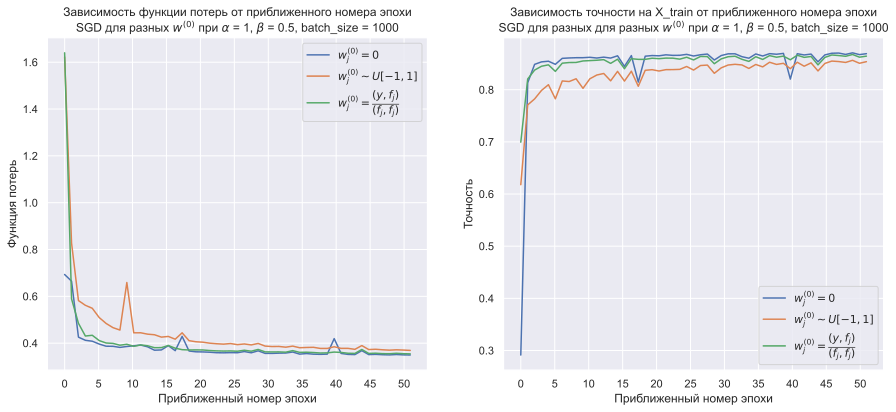

In [54]:
n_iters = 51
plt.figure(figsize=(15, 6))
x_ticks = np.arange(0, 51, 5)

plt.subplot(1, 2, 1)

labels = ["$w_j^{(0)} = 0$", r"$w_j^{(0)} \sim U[-1, 1]$", r"$w_j^{(0)} = \dfrac{(y, f_j)}{(f_j, f_j)}$"]

title_add = f" при $\\alpha$ = {step_alpha_sgd}, $\\beta$ = {step_beta_sgd}, batch_size = {BATCH_SIZE}"

for i in range(loss_arr_sgd_w.shape[0]):
    plt.plot(epoch_arr_w[i][:n_iters], loss_arr_sgd_w[i, :n_iters], label=labels[i])
    plt.title("Зависимость функции потерь от приближенного номера эпохи\nSGD для разных $w^{(0)}$" + title_add)
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(loss_arr_sgd_w.shape[0]):
    plt.plot(epoch_arr_w[i][:n_iters], acc_arr_sgd_w[i, :n_iters], label=labels[i])
    plt.title("Зависимость точности на X_train от приближенного номера эпохи\nSGD для разных для разных $w^{(0)}$" + title_add)
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)
    #plt.yscale("log")

savefig("5_w_0")
plt.show()

По-прежнему 3-й вариант лучший

### batch_size

In [32]:
MAX_ITER_SGD_BATCH = 50

#N_POINTS = 7
#batch_size_arr = np.logspace(np.log10(100), np.log10(50000), 7)
batch_size_arr = np.array([10, 100, 1_000, 10_000, 20_000, 50_000])

loss_arr_sgd_batch = np.zeros((batch_size_arr.shape[0], MAX_ITER_SGD_BATCH + 1))
acc_arr_sgd_batch = np.zeros_like(loss_arr_sgd_batch)
epoch_arr_batch = np.zeros_like(loss_arr_sgd_batch)

for i, batch_size in enumerate(tqdm(batch_size_arr)):
    batch_size = int(batch_size)
    sgdc = SGDClassifier(step_alpha=step_alpha_sgd, step_beta=step_beta_sgd, max_iter=MAX_ITER_SGD_BATCH, tolerance=0, batch_size=batch_size)
    history = sgdc.fit(X_train, y_train, trace=True, w_0=w_0)
    loss_arr_sgd_batch[i] = np.array(history["func"])
    acc_arr_sgd_batch[i] = np.array(history["accuracy"])
    epoch_arr_batch[i] = np.array(history["epoch_num"])

100%|██████████| 6/6 [02:37<00:00, 26.19s/it]


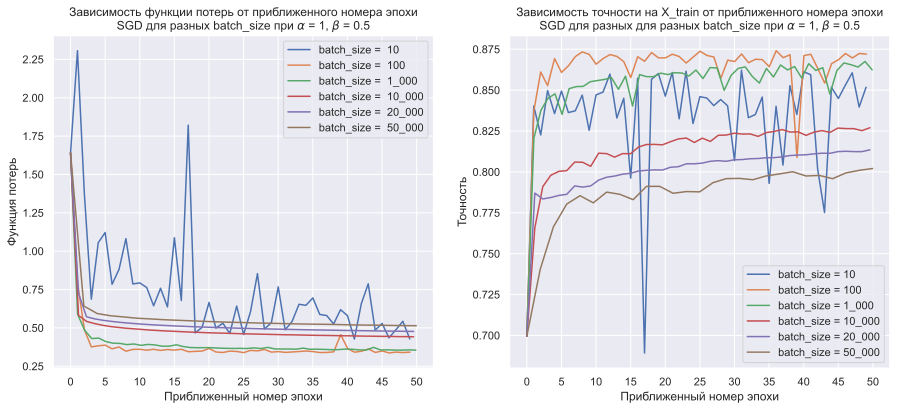

In [57]:
n_iters = 51
plt.figure(figsize=(15, 6))
x_ticks = np.arange(0, 51, 5)

plt.subplot(1, 2, 1)

title_add = f" при $\\alpha$ = {step_alpha_sgd}, $\\beta$ = {step_beta_sgd}"

for i in range(loss_arr_sgd_batch.shape[0]):
    x = epoch_arr_batch[i][:n_iters]
    y = loss_arr_sgd_batch[i, :n_iters]
    y = y[x <= 50]
    x = x[x <= 50]
    plt.plot(x, y, label=f"batch_size = {batch_size_arr[i] : _.0f}")
    plt.title("Зависимость функции потерь от приближенного номера эпохи\nSGD для разных batch_size" + title_add)
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Функция потерь")
    plt.legend()
    plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
for i in range(loss_arr_sgd_batch.shape[0]):
    x = epoch_arr_batch[i][:n_iters]
    y = acc_arr_sgd_batch[i, :n_iters]
    y = y[x <= 50]
    x = x[x <= 50]
    plt.plot(x, y, label=f"batch_size ={batch_size_arr[i] : _.0f}")
    plt.title("Зависимость точности на X_train от приближенного номера эпохи\nSGD для разных для разных batch_size" + title_add)
    plt.xlabel("Приближенный номер эпохи")
    plt.ylabel("Точность")
    plt.legend()
    plt.xticks(x_ticks)
    #plt.yscale("log")

savefig("5_batch_size")
plt.show()

1. batch_size <= 10 - плохо (скачки)
2. batch_size >= 10_000 - плохая сходимость
3. best_batch_size = 100

In [34]:
best_batch_size = 100

## EXP6: сравнение GD и SGD

In [35]:
gdc_best_params = {
    "step_alpha": step_alpha_gd,
    "step_beta": step_beta_gd
}

sgdc_best_params = {
    "step_alpha": step_alpha_sgd,
    "step_beta": step_beta_sgd,
    "batch_size": best_batch_size
}

In [36]:
gdc_best_params, sgdc_best_params

({'step_alpha': 1, 'step_beta': 0.1},
 {'step_alpha': 1, 'step_beta': 0.5, 'batch_size': 100})

In [50]:
MAX_ITER_6 = 1e10
TOL = 1e-5
gdc_best = GDClassifier(step_alpha=step_alpha_gd, step_beta=step_beta_gd, max_iter=MAX_ITER_6, tolerance=TOL)
sgdc_best = SGDClassifier(step_alpha=step_alpha_sgd, step_beta=step_beta_sgd, batch_size=best_batch_size, max_iter=MAX_ITER_6, tolerance=TOL)
start_gdc = time()
gdc.fit(X_train, y_train)
end_gdc = time()
print("gdc end")
start_sgdc = time()
sgdc.fit(X_train, y_train)
end_sgdc = time()

gdc end


In [51]:
t_gdc = end_gdc - start_gdc
t_sgdc = end_sgdc - start_sgdc
print(f"Время работы для достижения точности {TOL}")
t_gdc, t_sgdc, t_sgdc / t_gdc

Время работы для достижения точности 1e-05


(10.51888132095337, 3.9274470806121826, 0.3733711752017582)

In [39]:
MAX_ITER_6_2 = 1000
gdc_best = GDClassifier(step_alpha=step_alpha_gd, step_beta=step_beta_gd, max_iter=MAX_ITER_6_2, tolerance=0)
sgdc_best = SGDClassifier(step_alpha=step_alpha_sgd, step_beta=step_beta_sgd, batch_size=best_batch_size, max_iter=MAX_ITER_6_2, tolerance=0)
history_gdc = gdc_best.fit(X_train, y_train, trace=True)
history_sgdc = sgdc_best.fit(X_train, y_train, trace=True)

time_gdc_arr = np.array(history_gdc["time"])
loss_gdc_arr = np.array(history_gdc["func"])
acc_gdc_arr = np.array(history_gdc["accuracy"])

time_sgdc_arr = np.array(history_sgdc["time"])
loss_sgdc_arr = np.array(history_sgdc["func"])
acc_sgdc_arr = np.array(history_sgdc["accuracy"])

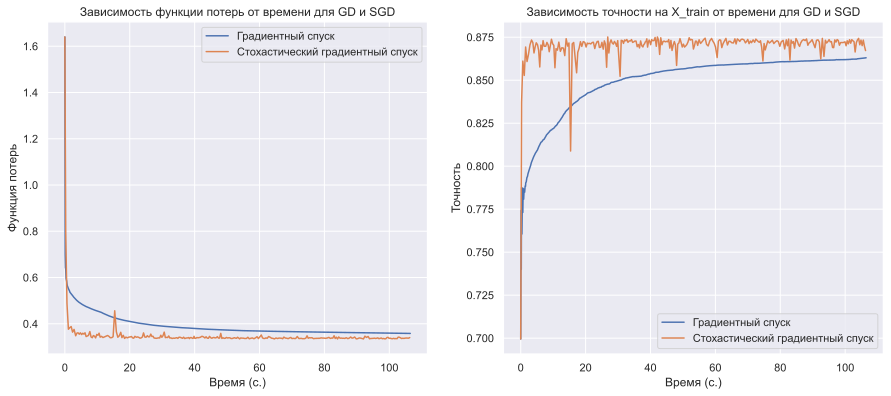

In [56]:
n_iters = MAX_ITER_6_2 + 1
plt.figure(figsize=(15, 6))
#x_ticks = np.arange(0, 51, 5)

mask = time_sgdc_arr[:n_iters] <= time_gdc_arr[:n_iters].max()

plt.subplot(1, 2, 1)
plt.plot(time_gdc_arr[:n_iters], loss_gdc_arr[:n_iters], label="Градиентный спуск")
plt.plot(time_sgdc_arr[:n_iters][mask], loss_sgdc_arr[:n_iters][mask], label="Стохастический градиентный спуск")
plt.title("Зависимость функции потерь от времени для GD и SGD")
plt.xlabel("Время (с.)")
plt.ylabel("Функция потерь")
plt.legend()
#plt.xticks(x_ticks)

plt.subplot(1, 2, 2)
plt.plot(time_gdc_arr[:n_iters], acc_gdc_arr[:n_iters], label="Градиентный спуск")
plt.plot(time_sgdc_arr[:n_iters][mask], acc_sgdc_arr[:n_iters][mask], label="Стохастический градиентный спуск")
plt.title("Зависимость точности на X_train от времени для GD и SGD")
plt.xlabel("Время (с.)")
plt.ylabel("Точность")
plt.legend()
#plt.xticks(x_ticks)
#plt.yscale("log")

savefig("6_loss_acc_time")
plt.show()

1. Обычный градиентный спуск сходится дольше, чем стохастический.
2. Обычный градиентный спуск сходится более плавно, на его графиках нет резких падений/скачков, как в случае со стохастическим градиентным спуском. 
3. ???  Для достижения заданной точности tolerance SGD нужно больше времени

In [94]:
gdc_best = GDClassifier(**gdc_best_params)
sgdc_best = SGDClassifier(**sgdc_best_params)
gdc_best.fit(X_train, y_train)
sgdc_best.fit(X_train, y_train)
y_pred_gdc = gdc_best.predict(X_test)
y_pred_sgdc = sgdc_best.predict(X_test)
acc_gdc = accuracy(y_test, y_pred_gdc)
acc_sgdc = accuracy(y_test, y_pred_sgdc)
print("Точность на X_test для gd и sgd")
acc_gdc, acc_sgdc

Точность на X_test для gd и sgd


(0.8196943315921842, 0.8241923002514994)

In [112]:
print(f"{acc_gdc = :.4f}, {acc_sgdc = :.4f}, {acc_sgdc - acc_gdc:.4f}")

acc_gdc = 0.8197, acc_sgdc = 0.8242, 0.0045


### EXP7

In [77]:
import nltk
nltk.download('wordnet')
train.head(10)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,comment_text,is_toxic
0,0,explanation why the edits made under my userna...,False
1,1,d aww he matches this background colour i m s...,False
2,2,hey man i m really not trying to edit war it...,False
3,3,more i can t make any real suggestions on impr...,False
4,4,you sir are my hero any chance you remember...,False
5,5,congratulations from me as well use the tools...,False
6,6,cocksucker before you piss around on my work,True
7,7,your vandalism to the matt shirvington article...,False
8,8,sorry if the word nonsense was offensive to ...,False
9,9,alignment on this subject and which are contra...,False


In [76]:
from nltk.stem import WordNetLemmatizer

wlt = WordNetLemmatizer()

lemm_train = train["comment_text"].copy()
lemm_test = test["comment_text"].copy()

for index, s in enumerate(tqdm(train["comment_text"])):
    lemm_train[index] = ' '.join([wlt.lemmatize(w) for w in s.split()])

for index, s in enumerate(tqdm(test["comment_text"])):
    lemm_test[index] = ' '.join([wlt.lemmatize(w) for w in s.split()])

100%|██████████| 20676/20676 [00:05<00:00, 3719.23it/s]


In [79]:
lemm_train.head(10)

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
5    congratulation from me a well use the tool wel...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense wa offensive to you...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [84]:
nltk.download("stopwords")
stops = set(nltk.corpus.stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
for data in (lemm_train, lemm_test):
    for index in data.index:
        data[index] = ' '.join(word if word not in stops else '' for word in data[index].split())
lemm_train.head(10)

0    explanation   edits made   username hardcore m...
1     aww  match  background colour   seemingly stu...
2    hey man   really  trying  edit war      guy  c...
3        make  real suggestion  improvement  wonder...
4                sir   hero  chance  remember  page   
5           congratulation    well use  tool well talk
6                      cocksucker   piss around   work
7     vandalism   matt shirvington article ha  reve...
8    sorry   word nonsense wa offensive   anyway   ...
9         alignment   subject    contrary    dulithgow
Name: comment_text, dtype: object

In [105]:
vectorizer = CountVectorizer(min_df=0.007)
X_train_lem = vectorizer.fit_transform(lemm_train)
X_test_lem = vectorizer.transform(lemm_test)

In [ ]:
sgd = SGDClassifier(**sgdc_best_params)
sgd.fit(X_train_lem, y_train)
pred = sgd.predict(X_test_lem)
acc_lem = accuracy(y_test, pred)

In [114]:
print(f"{acc_lem = :.4}, {acc_sgdc - acc_lem = :.4f}")

acc_lem = 0.8116, acc_sgdc - acc_lem = 0.0126


In [107]:
X_train.shape[1], X_train_lem.shape[1]

(774, 653)